# Robust estimation of multivariate location and shape
A tutorial of the method outlined in [*A Deterministic Method for Robust Estimation of Multivariate Location and Shape*](https://www.tandfonline.com/doi/abs/10.1080/10618600.1997.10474744), an improvement upon the classical minimum volume ellipsoid estimator.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [6]:
def titterington_algorithm(X, w=None, iterations=100):
    """
    Calculates the weighted Mahalanobis distance for each point and iteratively
    updates the weights until all distances are less than the dimension of the
    observations or the number of iterations is reached.
    """
    n,p = X.shape
    if w is None:
        w = np.ones(n) / n
    else:
        assert(w.shape[0] == n)
    
    # Weighted average as 
    c = w @ X

    # Covariance matrix
    S = (X-c).T @ np.diag(w) @ (X-c)
    
    # Compute Mahalanobis distances
    S_inv = np.linalg.inv(S)
    D = np.asarray([(x-c) @ S_inv @ (x-c).T for x in X])
    if np.any(D >= p) and iterations > 0:
        w = w * D / p
        return titterington_algorithm(X, w=w, iterations=iterations-1)
    else:
        return c, S_inv, np.sqrt(D)
    
def eid(X, m=None):
    """
    Computes the location and shape of a minimum volume ellipsoid around
    a set of points, invariant to m of those points.
    
    X : (n_samples, n_features)
        Data matrix
    m : int (default=None)
        Number of samples to keep. Set to a default if None
    """
    n,p = X.shape
    X0 = X.copy()
    if m is None:
        m = int(np.ceil((n+p+1)/ 2))
    for _ in range(n-m):
        Xj = X - X.mean(axis=0)
        eid = np.diag(Xj @ np.linalg.inv(Xj.T @ Xj) @ Xj.T)
        # Delete max eid value, excluding any with eid of 1
        max_eid = np.max(list(set(eid) - set([1])))
        X = np.delete(X, np.where(eid == max_eid)[0][0], 0)

    c, S_inv, _ = titterington_algorithm(X)
    D = np.sqrt([(x-c) @ S_inv @ (x-c).T for x in X0])

    return c, S_inv, D

We run our analyses on the [pulp fiber data](http://www-eio.upc.edu/~pau/cms/rdata/doc/robustbase/pulpfiber.html) as done in the original minimum volume ellipsoid (MVE) [paper](https://onlinelibrary.wiley.com/doi/abs/10.1002/wics.19). The dataset consists of 62 samples, each with four features and four target variables. We will only consider the four feature variables.

In [3]:
pulp_fiber = np.loadtxt('../../data/pulp_fiber.csv', delimiter=',',skiprows=1)[:,:4]

As we can see from the below plot of pairwise fatures, there are clear outliers in the data. Considering the data as a Gaussian point cloud, one may be inclined to estimate tendencies away from the center of the cloud using the Mahalanobis distance. However, this is sensitive to outliers which we clearly see.

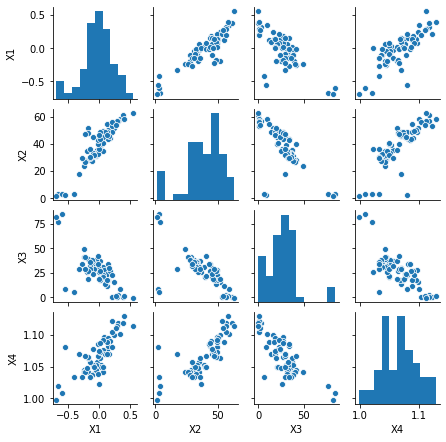

In [4]:
g = sns.pairplot(pd.DataFrame(data=pulp_fiber, columns=['X1', 'X2', 'X3', 'X4']), height=1.5)

We calculate both the Mahalanobis distance (left plot below) and the more robust EID distance (right plot below) which allows for a fraction of the observations to be excluded prior to estimation of the location and shape.

In [7]:
# Calculate the distances under the two learned metrics
_, _, D_eid = eid(pulp_fiber)
_, _, D_mah = titterington_algorithm(pulp_fiber, iterations=0)

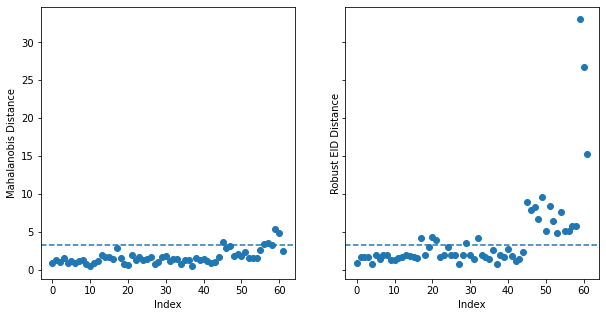

In [9]:
fig, axes = plt.subplots(1,2, figsize=(10,5), sharey=True)
idxs = np.arange(D_eid.shape[0])
axes[0].scatter(idxs, D_mah)
axes[1].scatter(idxs, D_eid)
axes[0].axhline(3.34, ls='--')
axes[1].axhline(3.34, ls='--')
axes[0].set_xlabel('Index')
axes[1].set_xlabel('Index')
axes[0].set_ylabel('Mahalanobis Distance')
axes[1].set_ylabel('Robust EID Distance')
plt.show()

If the data indeed follow a four-dimensional multivariate Gaussian distribution, then the Mahalanobis distance follows a squared Chi-squared distribution with four degrees of freedom. The dashed line is plotted at the value $\chi^2_{4,0.975}$ under which $0.975$ percent of the data should lie in such a case. of As we can see, the robust distance is much more indicative of a abhorrent behavior for a variety of the points observed, as evident in the points with extreme distances. The Mahalanobis distance reveals some outliers but is not strongly indicative.